In [1]:
import os
SIGN_LOCATION = '../../signDatabase'
data_base = 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations'
data_base = 'aiua120214-1/frameAnnotations-DataLog02142012_001_external_camera.avi_annotations'
data_dir = os.path.join(SIGN_LOCATION, data_base)
annotations_file = 'frameAnnotations.csv'
get_origin_path = lambda filename: os.path.join(data_dir, filename)
annotations_path = os.path.join(data_dir, annotations_file)

In [2]:
FILENAME = 'Filename'
CLASS = 'Annotation tag'
UL_X = 'Upper left corner X'
UL_Y = 'Upper left corner Y'
LR_X = 'Lower right corner X'
LR_Y = 'Lower right corner Y'

In [3]:
import csv

with open(annotations_path, newline='') as csvfile:
    annotations = csv.DictReader(csvfile, delimiter=';')
    
    for row in annotations:
        image_name = row[FILENAME]
        break
    
import cv2
image_path = os.path.join(data_dir, image_name)
image = cv2.imread(image_path)
height, width, _ = image.shape
print(height, width)

522 1024


In [4]:
classes = set()
with open(annotations_path, newline='') as csvfile:
    annotations = csv.DictReader(csvfile, delimiter=';')
    
    for row in annotations:
        classes.add(row[CLASS])
classes = list(classes)

In [5]:
classes

['signalAhead',
 'addedLane',
 'curveRight',
 'truckSpeedLimit55',
 'speedLimit35',
 'merge',
 'rightLaneMustTurn',
 'stop',
 'thruMergeLeft',
 'speedLimit65',
 'laneEnds',
 'rampSpeedAdvisory45',
 'speedLimit30',
 'pedestrianCrossing',
 'rampSpeedAdvisory40']

In [6]:
classes = ['stop']

In [7]:
def generate_label(tag, x_min, y_min, x_max, y_max, classes, width, height):
    """label_idx, x_center, y_center, width, height
        scaled by [0, 1]
    """
    label_idx = classes.index(tag)
    
    # Centers.
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    
    # Bounding Box: Width, Height.
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min
    
    # Scale.
    x_center_scaled = x_center / width
    y_center_scaled = y_center / height
    
    bbox_width_scaled = bbox_width / width
    bbox_height_scaled = bbox_height / height
    
    label = [
        label_idx,
        x_center_scaled,
        y_center_scaled,
        bbox_width_scaled,
        bbox_height_scaled
    ]
    
    label = map(str, label)
    
    # Format space seperated.
    label_string = ' '.join(label)
    
    return label_string
    

In [8]:
FLOAT_KEYS = [UL_X, UL_Y, LR_X, LR_Y]

formatted_data_dir = f"data/formatted-stop-test{data_base}"
get_path = lambda filename: os.path.join(formatted_data_dir, filename)
LABELS_DIR = 'labels'
LABELS_DIR_PATH = os.path.join(formatted_data_dir, LABELS_DIR)

IMAGES_DIR = 'images'
IMAGES_DIR_PATH = os.path.join(formatted_data_dir, IMAGES_DIR)

CLASSES_PATH = os.path.join(formatted_data_dir, 'classes.names')
TRAIN_PATH = os.path.join(formatted_data_dir, 'train.txt')
VALID_PATH = os.path.join(formatted_data_dir, 'valid.txt')

import os
import shutil
os.makedirs(LABELS_DIR_PATH, exist_ok=True)
os.makedirs(IMAGES_DIR_PATH, exist_ok=True)

open(TRAIN_PATH, 'w').close()
open(VALID_PATH, 'w').close()



with open(CLASSES_PATH, 'w') as f:
    for class_name in classes:
        class_name += '\n'
        f.write(class_name)

with open(annotations_path, newline='') as csvfile:
    annotations = csv.DictReader(csvfile, delimiter=';')
    
    keep = set(["stop"])
    seen = set()
    for row in annotations:
        # Only keep ones that we want.
        if row[CLASS] not in keep:
            continue
        for key in FLOAT_KEYS:
            row[key] = float(row[key])
        filename = row[FILENAME]
        base = os.path.splitext(filename)[0]
        label_filename = f"{base}.txt"
        
        label_file_path = os.path.join(LABELS_DIR_PATH, label_filename)
        label = generate_label(row[CLASS], row[UL_X], row[UL_Y], row[LR_X], row[LR_Y], classes, width, height)
        
        with open(label_file_path, 'w') as f:
            label += '\n'
            f.write(label)
        
        image_path_src = get_origin_path(filename)
        image_path_dst = os.path.join(IMAGES_DIR_PATH,filename)
        
        shutil.copy(image_path_src, image_path_dst)
        
        file_to_write = TRAIN_PATH
        
        if row[CLASS] not in seen:
            seen.add(row[CLASS])
            file_to_write = VALID_PATH
        
        with open(file_to_write, 'a') as f:
            image_path_dst += '\n'
            f.write(image_path_dst)
        
        

Text(964.0, 77.0, '')

<Figure size 432x288 with 0 Axes>

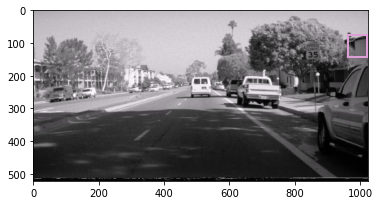

In [9]:
import cv2
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import random

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
bbox_colors = random.sample(colors, 10)
color = bbox_colors[0]

x1 = float(row[UL_X])
y1 = float(row[UL_Y])

box_w = float(row[LR_X]) - float(row[UL_X])
box_h = float(row[LR_Y]) - float(row[UL_Y])

# Create a Rectangle patch
bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
# Add the bbox to the plot
ax.add_patch(bbox)

plt.text(
    x1,
    y1,
    s='',
    color="white",
    verticalalignment="top",
    bbox={"color": color, "pad": 0},
)